In [1]:
# Copyright openai/gym. https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
# Revised by juhyeonglee

import random
import numpy as np
from collections import defaultdict

gamma = 1

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


# 0 : stack, 1 : hit
actions = [0, 1]


def draw_card(deck):
  return int(random.choice(deck))


def draw_hand(deck):
  return [draw_card(deck), draw_card(deck)]


def usable_ace(hand):  # Does this hand have a usable ace? True or False
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)

# draw_hand를 실행하고 그 값을 score에 집어넣으면 된다.


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

def dealer_score(dealerCards, deck):
  while score(dealerCards) < 17:
    dealerCards.append(draw_card(deck))
    if is_bust(dealerCards):
      return 0
  return score(dealerCards)

def player_card_setting(playerCards): # if player card sum < 12 then automatically draw
  while score(playerCards) < 12:
    playerCards.append(draw_card(deck))
  return playerCards

def is_pairs_dupli(episode, t, key):
  a = episode
  if t > 0:
    t -= 1
    while not t == 0:
      a_seq = a[t]
      iter_key = (a_seq[0], a_seq[1])
      if key == iter_key:
        return True
      else:
        t -= 1
    return False
  else:
    return False

def policy_improvement(pi_table, Q_table, s): # 특정 s에 대한 optimal action pi-table에 넣기
  Q_0 = Q_table[(s,0)]
  Q_1 = Q_table[(s,1)]
  if Q_0 > Q_1:
    pi_table[s] = 0
  else:
    pi_table[s] = 1

In [2]:
# Copyright juhyeonglee
# Return-table, Q-table initialization


Q_table = defaultdict(lambda : 0)
Return_table = defaultdict(lambda : [])
#pi_table = defaultdict(lambda : np.random.choice([0, 1]))
pi_table = defaultdict(lambda : 0)

In [3]:
def generate_episode(deck):
  # (s,a,r)를 쌓을 episode list 생성
  episode = []

  # 먼저 state를 정의하고 에피소드 진행. 그 안에서 첫 번째로 player와 딜러 모두 카드를 두장씩 받고 natural확인부터 해야함. 그런 다음 action진행
  
  # 플레이어, 딜러 카드 배분
  playerCards = draw_hand(deck)
  playerCards = player_card_setting(playerCards)
  dealerCards = draw_hand(deck)
  oneShowingCard = random.choice(dealerCards)

  # state정의
  state = (sum_hand(playerCards), oneShowingCard, usable_ace(playerCards))

  while True:
    # natural 확인
    if is_natural(playerCards): # player natural일 때
      action = 0 # 자동으로 stack
      if is_natural(dealerCards): # dealer도 natural이면
        r = 0 # 비김
        seq = (state, action, r)
        episode.append(seq)
        return episode
      else:
        r = 1
        seq = (state, action, r)
        episode.append(seq)
        return episode
    else: # player natural 아닐 때
      while True:
        action = random.choice(actions)
        if action == 0: # stack
          if score(playerCards) > dealer_score(dealerCards, deck): # won
            r = 1
            seq = (state, action, r)
            episode.append(seq)
            return episode
          elif score(playerCards) == dealer_score(dealerCards, deck): # 비김
            r = 0
            seq = (state, action, r)
            episode.append(seq)
            return episode
          else: # lost
            r = -1
            seq = (state, action, r)
            episode.append(seq)
            return episode
        else: # hit
          playerCards.append(draw_card(deck)) # 카드추가
          if is_bust(playerCards):
            r = -1
            seq = (state, action, r)
            episode.append(seq)
            return episode
          else:
            r = 0
            seq = (state, action, r)
            episode.append(seq)
            state = (sum_hand(playerCards), oneShowingCard, usable_ace(playerCards))

In [7]:
# MC ES

for _ in range(5000000):
  a = generate_episode(deck)
  #print("episode :", a)
  G = 0
  t = len(a) - 1 # 가장 마지막 step
  while not t < 0:
    a_seq = a[t] # 가장 마지막 sequence
    #print("sequence :",a_seq)
    key = (a_seq[0], a_seq[1]) # state, action
    R = a_seq[2]
    G = gamma*G + R
    if not is_pairs_dupli(a, t, key): # 한 에피소드 안에서 sequence 중복이 없다면
      Return_table[key].append(G)
      #print("Return_table(s,a) :",Return_table[key])
      Q_table[key] = np.mean(Return_table[key])
      #print("Q(s,a) : ",Q_table[key])
      policy_improvement(pi_table, Q_table, a_seq[0])
      #print("pi(s) :", pi_table[a_seq[0]])
    t -= 1

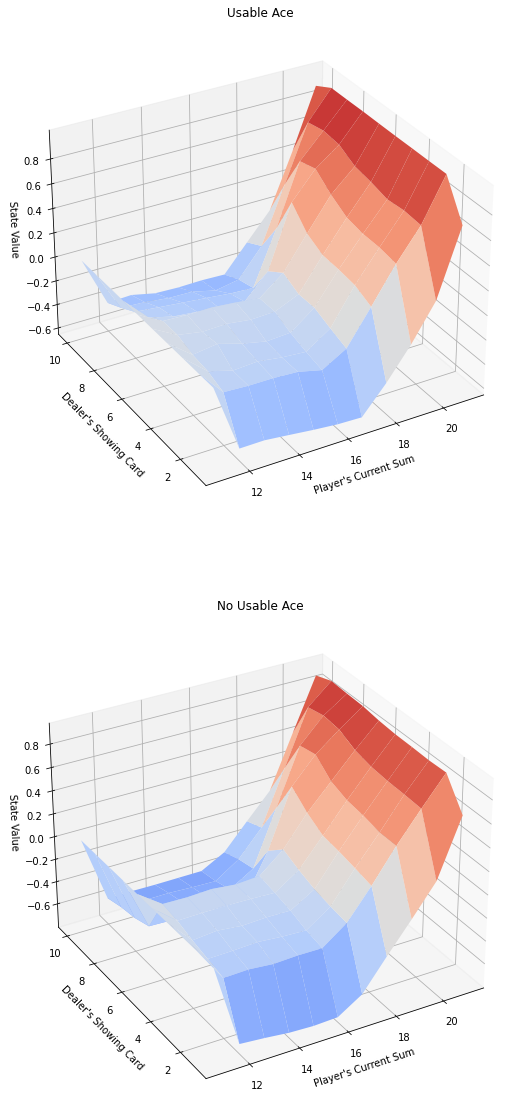

In [11]:
# plot
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_Z(x, y, usable_ace):
  if ((x,y,usable_ace),pi_table[(x,y,usable_ace)]) in Q_table:
      return Q_table[((x,y,usable_ace),pi_table[(x,y,usable_ace)])]
  else:
      return 0

def get_figure(usable_ace, ax):
  x_range = np.arange(11, 22)
  y_range = np.arange(1, 11)
  X, Y = np.meshgrid(x_range, y_range)

  Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

  surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
  ax.set_xlabel('Player\'s Current Sum')
  ax.set_ylabel('Dealer\'s Showing Card')
  ax.set_zlabel('State Value')
  ax.view_init(ax.elev, -120)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(211, projection='3d')
ax.set_title('Usable Ace')
get_figure(True, ax)
ax = fig.add_subplot(212, projection='3d')
ax.set_title('No Usable Ace')
get_figure(False, ax)
plt.show()

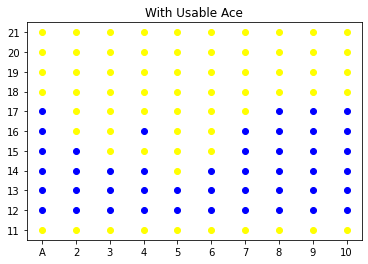

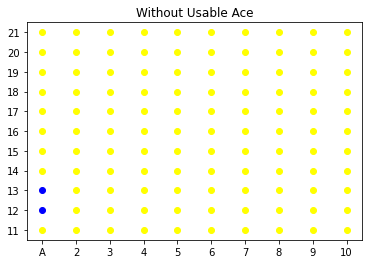

In [12]:
x11 = [ ]
y11 = [ ]

x12 = [ ]
y12 = [ ]

x21 = [ ]
y21 = [ ]

x22 = [ ]
y22 = [ ]

for pi_table_key in pi_table:
    if pi_table_key[2]: # if usable ace
        if pi_table[pi_table_key]: # if hit
            x11.append(pi_table_key[1] -1) # dealer showing
            y11.append(pi_table_key[0] - 11) # player sum
        else: # if stack
            x12.append(pi_table_key[1] -1)
            y12.append(pi_table_key[0] - 11)
    else: # if no-usable ace
        if pi_table[pi_table_key]: # if hit
            x21.append(pi_table_key[1] - 1)
            y21.append(pi_table_key[0] - 11)
        else:
            x22.append(pi_table_key[1] - 1)
            y22.append(pi_table_key[0] - 11)

plt.figure(0)
plt.title('With Usable Ace')
plt.scatter(x11, y11, color='blue')
plt.scatter(x12, y12, color='yellow')
plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

plt.figure(1)
plt.title('Without Usable Ace')
plt.scatter(x21, y21, color='blue')
plt.scatter(x22, y22, color='yellow')
plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

plt.show()